# "I Am An Individual!"...well maybe not to an organization

Growing up and through most of our adolescence and early adulthood, we are taught that human diversity -- be it gender, nationality, skill set, or even food preferences -- is a quality to be embraced. Of course this is true, but from a business perspective, treating everyone as an individual is a daunting task and very impractical, if not impossible (but we're working on it)!

This is the impetus for market segmentation. While we cannot easily serve our customers on an *individual* level just yet, we can do the next best thing -- uncover the similarities and differences between subsets of them, package them into neat little groups, and serve the *group's* needs. This can at least give our customers' a *sense* that we are speaking to them as an individual even if 100,000 of our other customers received, say, the same coupon in their email.

How do we segment our market? Typically one of the first approaches is by K-Means clustering (for the sake of brevity, I'll assume the reader has an understanding of how K-Means works, if not go [here](https://en.wikipedia.org/wiki/K-means_clustering)). K-Means is one of, if not the only, data clustering technique taught in statistics classes so it only makes sense that business analysts would jump to it if a project necessitated market segmentation. K-Means is, after all, fairly easy to understand under-the-hood and very efficient with large data sets we might see in a big data solution environment, but like all statistical methods there are underlying assumptions.

# Outside the "Sphere" of Influence

Real life data is almost always messy. The examples and illustrations we see in our statistics courses are designed to reflect ideal situations that sadly almost never occur in the real world. When the K-Means algorithm is run on a set of data, it's attempting to minimize the within-cluster variance with respect to the nearest centroid for how ever many centroids/clusters you told it to find a priori. This works best when your data is roughly "spherical" as in the toy data set below:

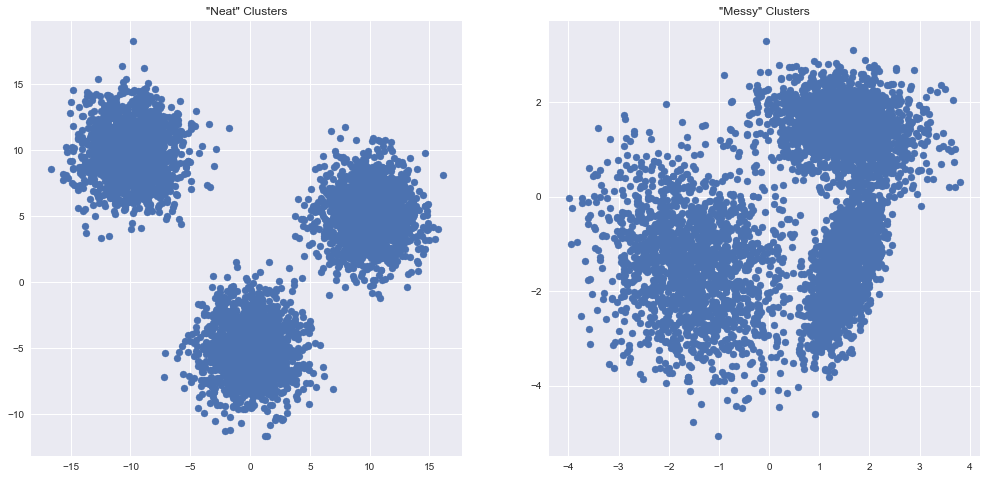

In [5]:
import matplotlib.pyplot as plt
from sklearn import datasets
%matplotlib inline

#Toy data sets
centers_neat = [(-10, 10), (0, -5), (10, 5)]
x_neat, _ = datasets.make_blobs(n_samples=5000, 
                                centers=centers_neat,
                                cluster_std=2,
                                random_state=2)

x_messy, _ = datasets.make_classification(n_samples=5000,
                                          n_features=10,
                                          n_classes=3,
                                          n_clusters_per_class=1,
                                          class_sep=1.5,
                                          shuffle=False,
                                          random_state=301)
#Default plot params
plt.style.use('seaborn')
cmap = 'tab10'

plt.figure(figsize=(17,8))
plt.subplot(121, title='"Neat" Clusters')
plt.scatter(x_neat[:,0], x_neat[:,1])
plt.subplot(122, title='"Messy" Clusters')
plt.scatter(x_messy[:,0], x_messy[:,1])

Our data set on the left seems to clearly exhibit having three well-defined, spherical clusters while the set on the right is a little more... nebulous. Is it two clusters? Maybe three? While a scatter plot allows us to inspect our data for obvious clusters, K-Means does not *see* like we do and will adhere to the algorithm.

Let's see how K-Means would cluster the above two data sets:

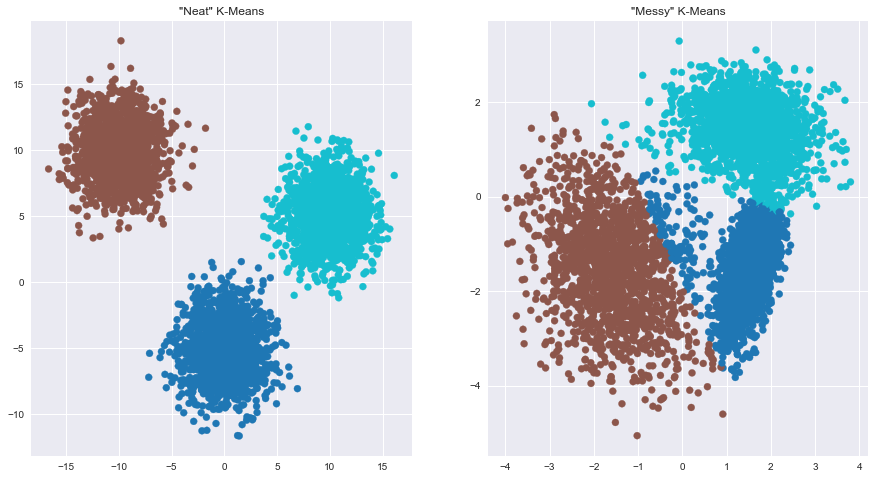

In [6]:
from sklearn.cluster import KMeans

#Predict K-Means cluster membership
km_neat = KMeans(n_clusters=3, random_state=2).fit_predict(x_neat)
km_messy = KMeans(n_clusters=3, random_state=2).fit_predict(x_messy)

plt.figure(figsize=(15,8))
plt.subplot(121, title='"Neat" K-Means')
plt.scatter(x_neat[:,0], x_neat[:,1], c=km_neat, cmap=cmap)
plt.subplot(122, title='"Messy" K-Means')
plt.scatter(x_messy[:,0], x_messy[:,1], c=km_messy, cmap=cmap)

Interesting results to say the least. While the performance on the "Neat" data set achieves excellent clustering, our "Messy" data set (while not clustered all *that* bad) is suboptimal. As stated before: visually, we can see two, maybe three, clusters but K-Means creates partitions that don't particularly reflect that. Our clusters are of varying shapes and variances which proves challenging for K-Means to work with.

Let's take a step back: what makes data "spherical" anyway? Our "Neat" clusters are composed of data points that are normally distributed and isotropic (i.e. the same variance in all directions) across the two dimensions of the plot. Our "Messy" data is normally distributed as well, but not isotropic (it's "anisotropic" for you real geeks). Furthermore, the "Messy" clusters aren't well separated so K-Means has a hard time judging which centroid each data point is closest to.

Now, while both data sets are artificially made, which one do you think you'd more likely see in reality? We need a way of clustering messier data!

### Gaussian Mixture Models (GMMs)

A classic example of how real-life data can exhibit a normal (Gaussian) distribution with non-uniform variance is peoples' height by gender. Both men and women have approximately normally distributed heights but their means and variances differ.

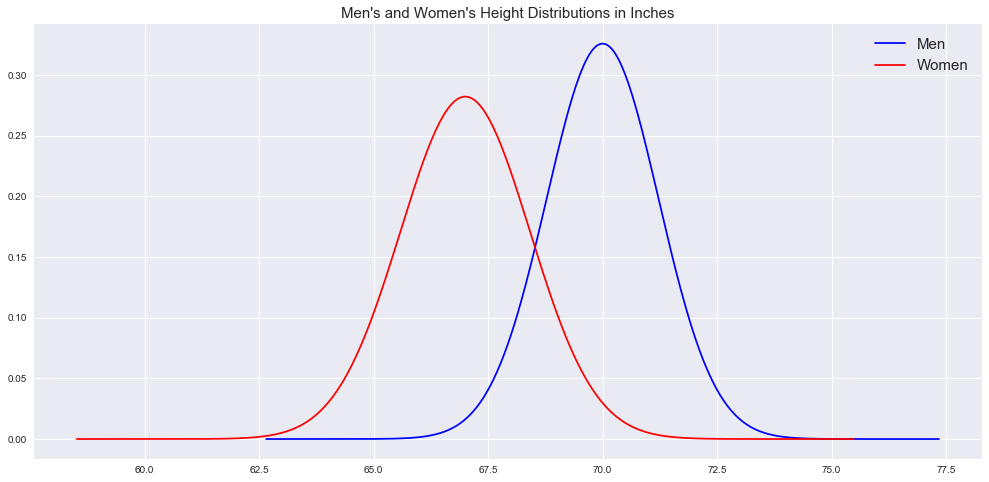

In [79]:
import numpy as np
import matplotlib.mlab as mlab
import math

men_mean = 70
men_var = 1.5
men_std = math.sqrt(men_var)
men_dist = np.linspace(men_mean - 6 * men_std, men_mean + 6 * men_std, 400)

women_mean = 67
women_var = 2
women_std = math.sqrt(women_var)
women_dist = np.linspace(women_mean - 6 * women_std, women_mean + 6 * women_std, 400)

plt.figure(figsize=(17,8))
plt.title('Men\'s and Women\'s Height Distributions in Inches', fontdict={'fontsize':15})
plt.plot(men_dist, mlab.normpdf(men_dist, men_mean, men_std), 'b-', label='Men')
plt.plot(women_dist, mlab.normpdf(women_dist, women_mean, women_std), 'r-', label='Women')
plt.legend(fontsize=15)

Above, we are shown which distribution belongs to which gender, but what if all we were given was a data set of heights and asked to determine the person's gender it came from? Sounds like a clustering problem, doesn't it? Say we randomly sample a height from our data and it's `69.2 inches`:

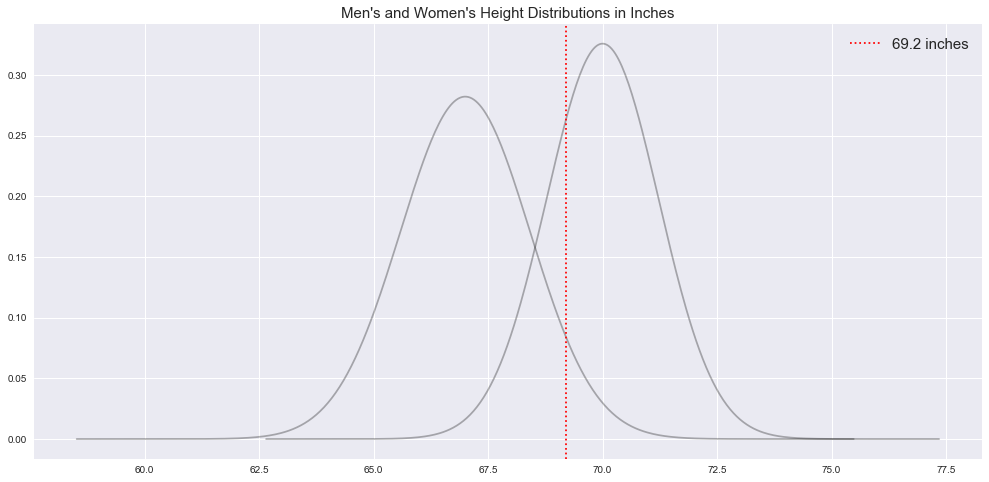

In [83]:
plt.figure(figsize=(17,8))
plt.title('Men\'s and Women\'s Height Distributions in Inches', fontdict={'fontsize':15})
plt.plot(men_dist, mlab.normpdf(men_dist, men_mean, men_std), 'k', alpha=.3)
plt.plot(women_dist, mlab.normpdf(women_dist, women_mean, women_std), 'k', alpha=.3)
plt.axvline(x=69.2, c='r', linestyle=":", label='69.2 inches')
plt.legend(fontsize=15)

Gaussian Mixture Models, or GMMs, work differently than K-Means in that they allow for directional variation (although still assume approximate normality) and that they are a "soft clustering" method. Based on the above plot, we can see that `69.2 inches` has a higher probability of coming from the male height distribution (because we "peeked" in our previous plot), but their is also a probability that it *could* be a female's height. We cheated a bit too because we created the distributions *then* fit a data point. In our example we said we'd be given a data set of *just* heights so the parameters that created these men/women height distributions would be *unknown* to us a priori.

Simply put, GMMs fit a number of normal distributions to our data set by estimating their parameters using what's called **Expectation Maximization**. This is a two step iterative algorithm (in some ways similar to K-Means): 

1. **Expectation**: Generate a number of distributions with reasonable parameters (mean and variance) based on the given data then "ask" every data point how likely is it to fall within each. Like K-Means, you need to specify the number of clusters, or in this case we call them "components," a priori.

2. **Maximization**: Iterate and update our distribution parameters to maximize the data points' likelihood of being assigned to the most probable cluster.

Let's go back to our "Messy" data set:

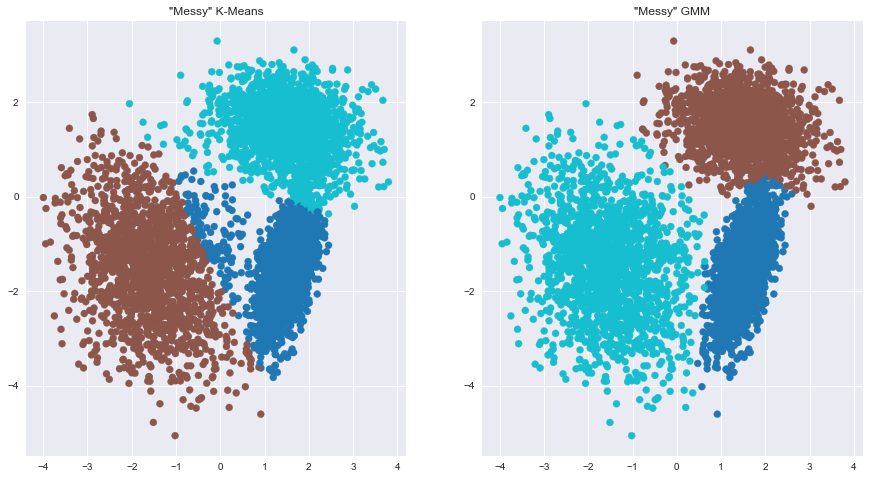

In [84]:
from sklearn.mixture import GaussianMixture

#Predict GMM cluster membership
gm_messy = GaussianMixture(n_components=3).fit(x_messy).predict(x_messy)

plt.figure(figsize=(15,8))
plt.subplot(121, title='"Messy" K-Means')
plt.scatter(x_messy[:,0], x_messy[:,1], c=km_messy, cmap=cmap)
plt.subplot(122, title='"Messy" GMM')
plt.scatter(x_messy[:,0], x_messy[:,1], c=gm_messy, cmap=cmap)

Looks much better, right? 

* **PROS**: GMM allows data to vary anisotropically and provides probability estimates of cluster membership rather than "hard labeling" data points like K-Means.

* **CONS**: GMM still assumes normal distributions across dimensions and needs then number of components/clusters specified a priori.

# Noises Off

If you were to develop a customer segmentation model for your retail business, there is little doubt your clusters would contain a varying number of customers. The real world is never *that* kind to analysts! In our above example with GMMs the toy data was generated with `n ~ 1,667` in each cluster (or, `5000 / 3`). What would happen if cluster membership was imbalanced?

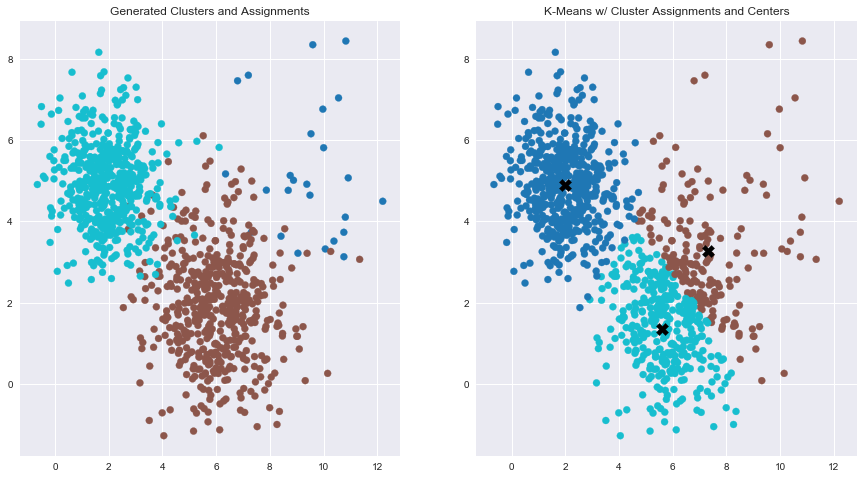

In [87]:
#Toy data set
blob1, y1 = datasets.make_blobs(n_samples=25, 
                               centers=[(10,5)],
                               cluster_std=1.5,
                               random_state=2)

blob2, y2 = datasets.make_blobs(n_samples=500, 
                               centers=[(6,2)],
                               cluster_std=1.3,
                               random_state=2)

blob3, y3 = datasets.make_blobs(n_samples=500, 
                               centers=[(2,5)],
                               cluster_std=1,
                               random_state=2)

unbal = np.vstack([blob1, blob2, blob3])
y1[y1 == 0] = 0
y2[y2 == 0] = 1
y3[y3 == 0] = 2
labs = np.concatenate([y1, y2, y3])

#Predict K-Means cluster membership
km_unbal = KMeans(n_clusters=3, random_state=2).fit(unbal)
km_unbal_preds = KMeans(n_clusters=3, random_state=2).fit_predict(unbal)

plt.figure(figsize=(15,8))
plt.subplot(121, title='Generated Clusters and Assignments')
plt.scatter(unbal[:,0], unbal[:,1], c=labs, cmap=cmap)
plt.subplot(122, title='K-Means w/ Cluster Assignments and Centers')
plt.scatter(unbal[:,0], unbal[:,1], c=km_unbal_preds, cmap=cmap)
plt.scatter(km_unbal.cluster_centers_[:,0], km_unbal.cluster_centers_[:,1], marker='X', s=150, c='black')

On the left side is the raw data generated so `n = 500` for both the turquoise and brown clusters and `n = 25` for the blue cluster -- clearly unbalanced. If we try to cluster our data points using K-Means again under the assumption that there are three clusters, we see what happens in the right side plot. Not pretty!

Since the K-Means algorithm is trying to minimize the sum or squared differences *within* each cluster, our centroids are naturally "pulled" towards larger, denser clusters. If the number of clusters is not known a priori we can estimate it using the [silhouette score](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) to determine the best number. Yet this brings up another consideration: what if some data points don't belong in *any* cluster? What if they are outliers/noise? Both K-Means and GMMs include *every data point in a cluster no matter how far away it is from the nearest centroid*.

### HDBSCAN

Density-based clustering methods are one way of addressing these situations with the most popular method being DBSCAN (Density-Based Spatial Clustering of Applications with Noise). DBSCAN differs from K-Means in a few important ways:

DBSCAN does not require the analyst to select the number of clusters a priori -- the algorithm determines this based on the parameters it's given
It excels at clustering non-spherical data
It does not force every data point into a cluster -- if a data point lies outside of the specified starting parameters, it will be classified as "noise" and not included in any resulting cluster.

Rather than randomly initialize centroids within our 2D data set and shuffle them into the best position, DBSCAN looks at each data point individually. DBSCAN relies on two parameters:

1. Epsilon, or "eps," is a measure of radial distance extending from a data point. Larger epsilon means a larger distance from a data point is considered when determining if another data point should be considered in its "neighborhood" and vice versa.
2. Minimum Points the number of other data points within another data point's "neighborhood" for it to be considered a "core" data point.

Let's visualize this:

In [88]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.stack.imgur.com/5aikc.png")

The [image](https://i.stack.imgur.com/5aikc.png) above shows how DBSCAN parameters work. The circles from each data point represent the epsilon distance. For a data point to be considered "core" and therefor "clusterable" it needs to have the minimum number of data points fall within its epsilon radius (in this example 4 including the data point itself). "Border" points are also in the core clusters and form their edges. The blue data point has neither the minimum number of data points in its neighborhood nor does it fall within a core data point's neighborhood and is thus labeled as "noise."

A major drawback with DBSCAN is that it's sensitive to the epsilon and minimum points parameters you give it. I can attest -- while writing this article I tinkered with parameters that differed only marginally but went from finding clusters to finding all noise on the same data set. The difference between setting "eps" at "4" vs. "5" could completely stop DBSCAN from working appropriately.

An evolved version of DBSCAN called **"HDBSCAN"** (the **H** for "Hierarchical") attempts to allow for clusters of differing variances/densities. [HDBSCAN](http://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) really only requires us to provide one parameter: minimum cluster size. Think of it like Hierarchical/Agglomerative clustering (that *other* clustering method you may have been taught in stats class): every data point starts as part of its own cluster and iteratively clusters with the next nearest data points until all data points are clustered together. The minimum cluster size parameter allows us to toss out clusters below this threshold. 

It's more intuitive from a business standpoint to determine what size a cluster/segment needs to be in order for it to be considered "actionable" (i.e. you aren't going to create a targeting marketing campaign for 5 customers but you might for 50,000).

Let's see how HDBSCAN handles our unbalanced/noisy data with a variety of minimum cluster size parameters:

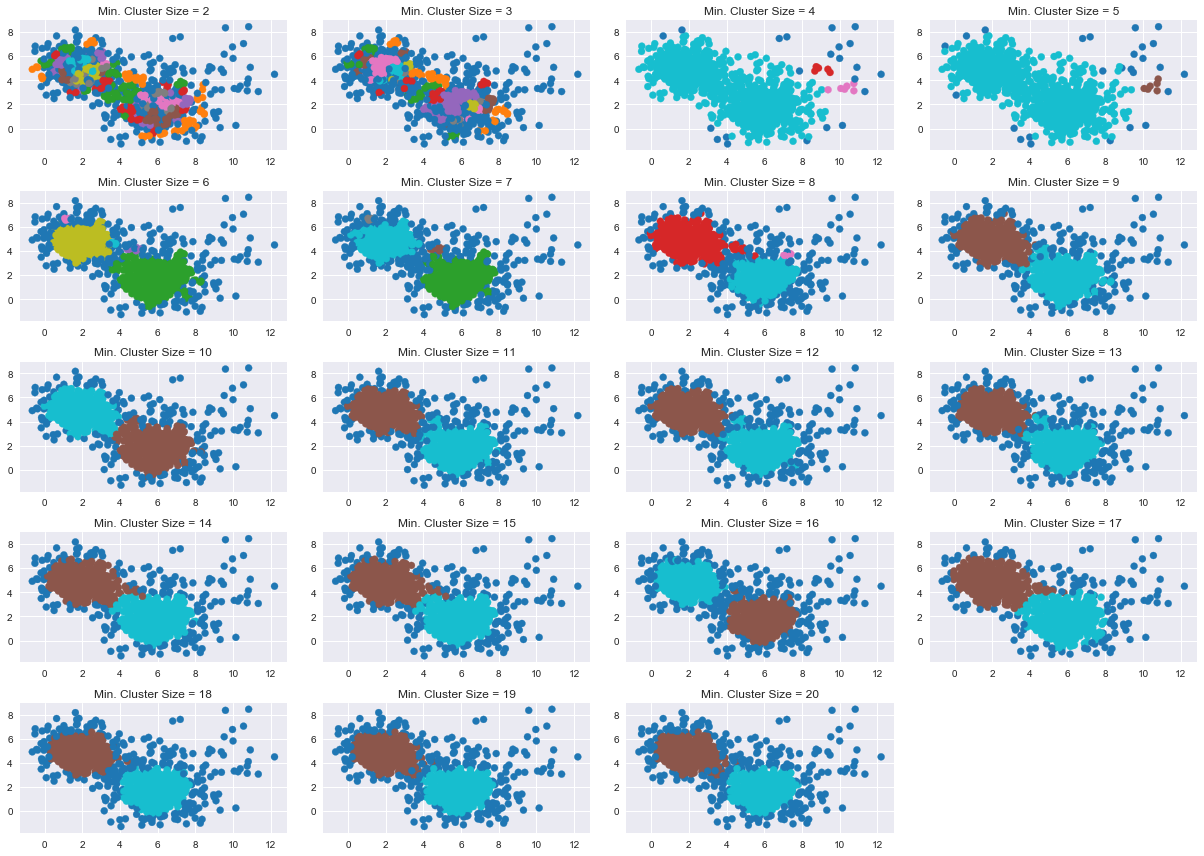

In [89]:
import hdbscan

clust_count = np.linspace(1, 20, num=20, dtype='int')

clust_number = 2
plot_number = 1
plt.figure (figsize=(17,12))
while clust_number < 21:
    hdb = hdbscan.HDBSCAN(min_cluster_size=clust_number)
    hdb_pred = hdb.fit(unbal)
    plt.subplot(5, 4, plot_number, title = 'Min. Cluster Size = {}'.format(clust_number))
    plt.scatter(unbal[:,0], unbal[:,1], c=hdb_pred.labels_, cmap=cmap)
    plot_number += 1
    clust_number += 1
    
plt.tight_layout()

The image above shows the minimum cluster size parameter from two to 20. You can see with smaller cluster sizes that nearly every data point is considered in its own cluster. Not very helpful. Yet as we enlarge this number we begin to see something more useful. Around a minimum cluster size of nine, two distinct clusters begin to form. Gradually increasing this value we see that clusters get smaller with more and more data points labeled as noise (the darker blue colored ones).

* **PROS**: Does not require the number of clusters to be set a priori and allows for noisy data
* **CONS**: Relies on the density of data points so sparse data sets may not work well and may lose efficiency on higher dimensional data sets

# So Long K-Means?

K-Means is still a very useful algorithm for clustering and by no way am I attempting to get you, the reader, to toss it aside! However, every analyst can benefit from a more robust set of tools at their disposal.

---
John Sukup is founder and Principal Consultant at Expected X. We bring sanity to businesses by making them feel secure with data solutions. We add structure to ambiguity through data engineering, modeling, and execution –- and most importantly: we derive value you can use to grow. With this knowledge in hand, we help you identify and develop opportunities you can exploit to grow both your business and its data maturity. John resides on the beautiful Big Island of Hawaii.